# SIR model

Here we calibrate a differentiable version of the SIR model.
We use the exact same model as  https://ndlib.readthedocs.io/en/latest/reference/models/epidemics/SIR.html,
but implemented in a differentiable way.

In [1]:
from blackbirds.models.sir import SIR
from blackbirds.infer.vi import VI
from blackbirds.simulate import simulate_and_observe_model

import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx
import normflows as nf
import pygtc

## Generating synthetic true data

In [2]:
device = "cpu"

In [3]:
# generate a random graph
n_agents = 1000
graph = networkx.watts_strogatz_graph(n_agents, 10, 0.1)

In [4]:
sir = SIR(graph, n_timesteps=100, device=device)

In [8]:
%%time
# the simulator takes as parameters the log10 of the fraction of initial cases, beta, and gamma parameters
true_parameters = torch.log10(torch.tensor([0.05, 0.05, 0.05], device=device))
data = sir.run_and_observe(true_parameters)
true_infected, true_recovered = data

CPU times: user 77.7 ms, sys: 3.07 ms, total: 80.8 ms
Wall time: 81.7 ms


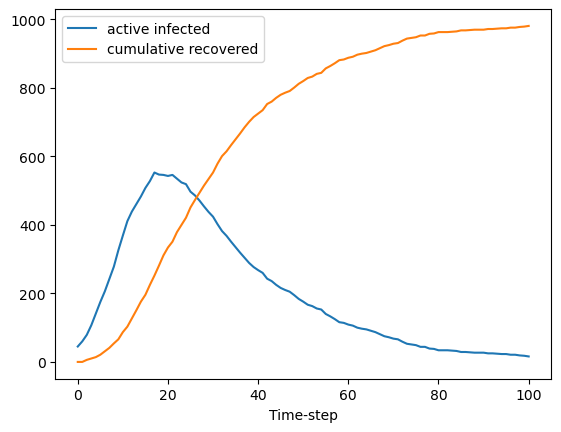

In [9]:
f, ax = plt.subplots()
ax.plot(true_infected.cpu(), label = "active infected")
ax.set_xlabel("Time-step")
ax.plot(true_recovered.cpu(), label = "cumulative recovered")
ax.legend()

## Approximating the posterior by a normalizing flow

We construct the flow using the normflows library (https://github.com/VincentStimper/normalizing-flows )

In this case we define Neural Spline Flow with 4 transformations, each parametrised by 2 layers with 64 hidden units.

In [10]:
def make_flow(n_parameters):
    torch.manual_seed(0)
    base = nf.distributions.base.DiagGaussian(n_parameters)
    num_layers = 5
    flows = []
    for i in range(num_layers):
        param_map = nf.nets.MLP([n_parameters // 2 + 1, 50, 50, 2], init_zeros=True)
        flows.append(nf.flows.AffineCouplingBlock(param_map))
        flows.append(nf.flows.Permute(n_parameters, mode='swap'))
    return nf.NormalizingFlow(base, flows).to(device)

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Ari

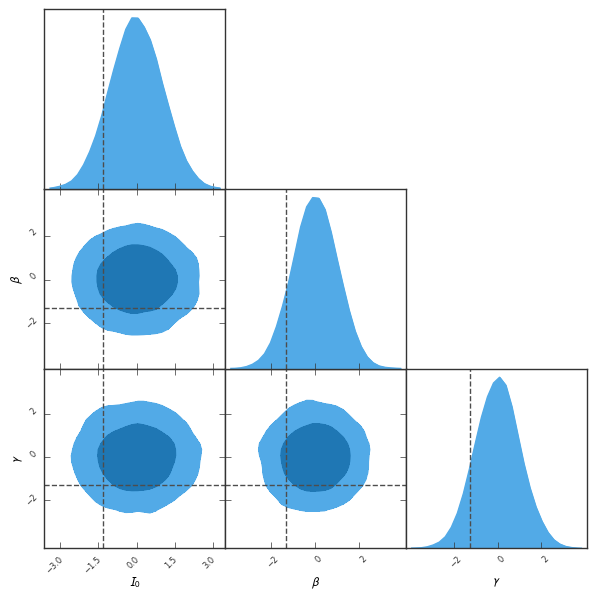

In [11]:
# Plot the inital flow:
flow = make_flow(len(true_parameters))
samples = flow.sample(10000)[0].cpu().detach().numpy()

pygtc.plotGTC([samples], truths=true_parameters.cpu().numpy(), figureSize=7, paramNames=[r"$I_0$", r"$\beta$", r"$\gamma$"]);

Let's also plot runs sampled from the untrained flow, to compare later with the trained flow.

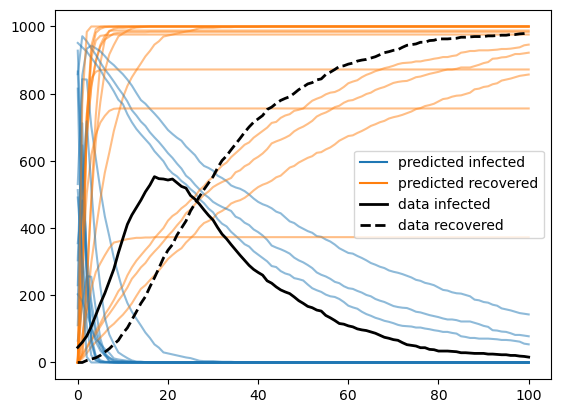

In [13]:
f, ax = plt.subplots()

for i in range(15):
    with torch.no_grad():
        sim_sir = sir.run_and_observe(flow.sample(1)[0][0])
    ax.plot(sim_sir[0].cpu().numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].cpu().numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(data[0].cpu(), color = "black", linewidth=2, label = "data infected")
ax.plot(data[1].cpu(), color = "black", linewidth=2, label = "data recovered", linestyle="--")
ax.legend()

### Train the flow

In [14]:
torch.manual_seed(0)

class L2Loss:
    def __init__(self, model):
        self.model = model
        self.loss_fn = torch.nn.MSELoss()
        
    def __call__(self, params, data):
        observed_outputs = simulate_and_observe_model(self.model, params)
        return self.loss_fn(observed_outputs[0], data[0])

prior = torch.distributions.MultivariateNormal(-2.0 * torch.ones(3, device=device), torch.eye(3, device=device))
loss = L2Loss(sir)
optimizer = torch.optim.AdamW(flow.parameters(), lr=1e-3)
w = 100

vi = VI(loss = loss,
        posterior_estimator = flow,
        prior=prior,
        data=data,
        optimizer=optimizer,
        w=w,
        n_samples_per_epoch=10,
        log_tensorboard=True,
        device=device
       )

# and we run for 1000 epochs, stopping if the loss doesn't improve in 100 epochs.
vi.run(n_epochs=1000, max_epochs_without_improvement=100);

  0%|                                                                                                                                       | 0/1000 [00:00<?, ?it/s]

GradTrackingTensor(lvl=1, value=
    tensor(41407.6641, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78896.6719, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(67668.3828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80175.5312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83782.4922, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82866.1797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77423.7109, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(45761.5820, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83146.2500, device='cuda:0')
)


  0%|                                               | 1/1000 [00:02<41:09,  2.47s/it, loss=7.2e+4, reg.=602, total=7.26e+4, best loss=7.2e+4, epochs since improv.=0]

GradTrackingTensor(lvl=1, value=
    tensor(78565.9609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80058.7344, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77418.9609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(42576.2578, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(58649.0273, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(50016.4453, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(69338.0156, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82065.9609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(41041.8906, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72541.9609, device='cuda:0')
)


  0%|                                             | 2/1000 [00:04<40:07,  2.41s/it, loss=6.55e+4, reg.=601, total=6.61e+4, best loss=6.55e+4, epochs since improv.=0]

GradTrackingTensor(lvl=1, value=
    tensor(81392.6016, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82131.8516, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81312.0469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(68661.9219, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(65158.3867, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79620.5547, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76031.2500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83388.9688, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77643.1094, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77198.7188, device='cuda:0')
)


  0%|▏                                            | 3/1000 [00:07<39:10,  2.36s/it, loss=7.66e+4, reg.=601, total=7.72e+4, best loss=6.55e+4, epochs since improv.=1]

GradTrackingTensor(lvl=1, value=
    tensor(79955.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81152.8516, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77493.2891, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78121.3516, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72635.0156, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(42626.7812, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75637.0078, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72281.5312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77142.2031, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72594.1016, device='cuda:0')
)


  0%|▏                                            | 4/1000 [00:09<38:57,  2.35s/it, loss=7.32e+4, reg.=608, total=7.38e+4, best loss=6.55e+4, epochs since improv.=2]

GradTrackingTensor(lvl=1, value=
    tensor(82451.6797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73948.4766, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77094.7031, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80622.3828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75834.5547, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75548.7422, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79927.7734, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(31781.9902, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80809.7188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80383.5156, device='cuda:0')
)


  0%|▏                                            | 5/1000 [00:11<38:51,  2.34s/it, loss=7.23e+4, reg.=616, total=7.29e+4, best loss=6.55e+4, epochs since improv.=3]

GradTrackingTensor(lvl=1, value=
    tensor(75732.6406, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82529.6484, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72990.7734, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82873.1406, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76248.2578, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77464.2188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76426.1250, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(70530.6562, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80991.9453, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81955.3047, device='cuda:0')
)


  1%|▎                                            | 6/1000 [00:14<38:54,  2.35s/it, loss=7.77e+4, reg.=618, total=7.84e+4, best loss=6.55e+4, epochs since improv.=4]

GradTrackingTensor(lvl=1, value=
    tensor(75381.1172, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80685.6094, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77849.8516, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(88100.8828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74664.5000, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79583.0859, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80641.4609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72051.0469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81244.9062, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78175.9922, device='cuda:0')
)


  1%|▎                                            | 7/1000 [00:16<38:49,  2.35s/it, loss=7.85e+4, reg.=620, total=7.91e+4, best loss=6.55e+4, epochs since improv.=5]

GradTrackingTensor(lvl=1, value=
    tensor(71928.4219, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(62117.4258, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75703.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79502.3750, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(46690.2070, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80367.1250, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78800.2500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78366.3438, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77104., device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(48970.8984, device='cuda:0')
)


  1%|▍                                               | 8/1000 [00:18<38:32,  2.33s/it, loss=7e+4, reg.=622, total=7.06e+4, best loss=6.55e+4, epochs since improv.=6]

GradTrackingTensor(lvl=1, value=
    tensor(72068.5703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80931.8281, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79933.0312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(53107.3242, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75808.4609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82317.9688, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72887.7344, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76039.1562, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77792.7500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79398.8906, device='cuda:0')
)


  1%|▍                                            | 9/1000 [00:21<38:48,  2.35s/it, loss=1.16e+5, reg.=630, total=1.16e+5, best loss=6.55e+4, epochs since improv.=7]

GradTrackingTensor(lvl=1, value=
    tensor(406448.9375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80800.7500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81827.8672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75441.4375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75374.9766, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72186.3672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78847.6797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76704.0859, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79221.4453, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77721.3828, device='cuda:0')
)


  1%|▍                                            | 10/1000 [00:23<39:33,  2.40s/it, loss=7.74e+4, reg.=625, total=7.8e+4, best loss=6.55e+4, epochs since improv.=8]

GradTrackingTensor(lvl=1, value=
    tensor(75428.5469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80767.7344, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73220.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(64641.5820, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81237.7422, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80710.5547, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(445854.1250, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80528.0312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76757.9062, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76896.3047, device='cuda:0')
)


  1%|▍                                           | 11/1000 [00:26<39:19,  2.39s/it, loss=1.14e+5, reg.=630, total=1.14e+5, best loss=6.55e+4, epochs since improv.=9]

GradTrackingTensor(lvl=1, value=
    tensor(76939.2344, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78461.7031, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82404.5000, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81852.0156, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73042.2656, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76131.8984, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75646.3828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(84146.9453, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(33970.4648, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79288.3672, device='cuda:0')
)


  1%|▌                                             | 12/1000 [00:28<39:17,  2.39s/it, loss=8e+4, reg.=627, total=8.06e+4, best loss=6.55e+4, epochs since improv.=10]

GradTrackingTensor(lvl=1, value=
    tensor(135105.9375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72454.7422, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(46519.6328, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79530.6641, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77823.2656, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(60713.4453, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(50186.6211, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81781.7500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(62354.7109, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(85897.2031, device='cuda:0')
)


  1%|▌                                           | 13/1000 [00:30<39:30,  2.40s/it, loss=6.8e+4, reg.=629, total=6.87e+4, best loss=6.55e+4, epochs since improv.=11]

GradTrackingTensor(lvl=1, value=
    tensor(76815.5469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(61629.4844, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74706.1172, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80105.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79967.9062, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(49138.7812, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77333.8906, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76738.8125, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78170.0469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72806.0156, device='cuda:0')
)


  1%|▌                                          | 14/1000 [00:33<39:31,  2.40s/it, loss=7.33e+4, reg.=628, total=7.39e+4, best loss=6.55e+4, epochs since improv.=12]

GradTrackingTensor(lvl=1, value=
    tensor(82354.0781, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80825.6016, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77102.2500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82929.7969, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73170.3281, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78811.3125, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83126.6953, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(84007.1875, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79553.6328, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79964.0469, device='cuda:0')
)


  2%|▋                                          | 15/1000 [00:35<39:31,  2.41s/it, loss=7.89e+4, reg.=635, total=7.95e+4, best loss=6.55e+4, epochs since improv.=13]

GradTrackingTensor(lvl=1, value=
    tensor(69222.3750, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79290.6406, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(65971.3672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(287541.1875, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(70093.6797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80985.3359, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78441.1875, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72003.2734, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74252.0469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79533.9609, device='cuda:0')
)


  2%|▋                                          | 16/1000 [00:38<39:26,  2.40s/it, loss=9.87e+4, reg.=626, total=9.93e+4, best loss=6.55e+4, epochs since improv.=14]

GradTrackingTensor(lvl=1, value=
    tensor(80816.1484, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(56407.4062, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79448.8828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74304.5000, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80865.7969, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74175.7188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80046.4844, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73955.5938, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81161.1797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79561.5234, device='cuda:0')
)


  2%|▋                                          | 17/1000 [00:40<39:15,  2.40s/it, loss=7.22e+4, reg.=631, total=7.28e+4, best loss=6.55e+4, epochs since improv.=15]

GradTrackingTensor(lvl=1, value=
    tensor(42190.6523, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73562.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80168.9688, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77118.1406, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77879.0078, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(16377.5645, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79116.3828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80387.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(55156.3164, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(66770.4375, device='cuda:0')
)


  2%|▊                                          | 18/1000 [00:42<39:09,  2.39s/it, loss=6.71e+4, reg.=621, total=6.77e+4, best loss=6.55e+4, epochs since improv.=16]

GradTrackingTensor(lvl=1, value=
    tensor(52619.0195, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80416.7188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76993.9297, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80485.7578, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(58453.8398, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77648.0547, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(415111.3750, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79801.7109, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81115.8125, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(537520.1250, device='cuda:0')
)


  2%|▊                                          | 19/1000 [00:45<39:04,  2.39s/it, loss=1.56e+5, reg.=631, total=1.57e+5, best loss=6.55e+4, epochs since improv.=17]

GradTrackingTensor(lvl=1, value=
    tensor(71711.8984, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83533.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78457.4766, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(48908.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77256.2734, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(52688.0586, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73614.6953, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81654.9688, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83123.6953, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83028.3047, device='cuda:0')
)


  2%|▊                                          | 20/1000 [00:47<38:44,  2.37s/it, loss=7.42e+4, reg.=627, total=7.48e+4, best loss=6.55e+4, epochs since improv.=18]

GradTrackingTensor(lvl=1, value=
    tensor(79524.0781, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80357.9375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78983.1094, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(64371.8789, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82799.9297, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80886.3672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74715.3672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81621.5469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(59975.6523, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76799.9062, device='cuda:0')
)


  2%|▉                                          | 21/1000 [00:49<38:35,  2.37s/it, loss=7.48e+4, reg.=622, total=7.54e+4, best loss=6.55e+4, epochs since improv.=19]

GradTrackingTensor(lvl=1, value=
    tensor(67191.2734, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76612.5234, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(52238.3477, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82462.3750, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77079.3438, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80865.4141, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81147.6797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77438.2031, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(52638., device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76437., device='cuda:0')
)


  2%|▉                                          | 22/1000 [00:52<38:35,  2.37s/it, loss=7.26e+4, reg.=619, total=7.32e+4, best loss=6.55e+4, epochs since improv.=20]

GradTrackingTensor(lvl=1, value=
    tensor(77181.8203, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77950.6484, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(46685.2188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(74483.8828, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77985.0391, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78704.5703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77210.5312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83549.5938, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80589.9766, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73966.6719, device='cuda:0')
)


  2%|▉                                          | 23/1000 [00:54<38:52,  2.39s/it, loss=7.15e+4, reg.=622, total=7.21e+4, best loss=6.55e+4, epochs since improv.=21]

GradTrackingTensor(lvl=1, value=
    tensor(44025.9102, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76768.8594, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72975.2500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76372.7812, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(70400.6250, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76233.0859, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81976.1875, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(66829.0391, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72356.3984, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(57031.8516, device='cuda:0')
)


  2%|█                                          | 24/1000 [00:57<39:01,  2.40s/it, loss=7.12e+4, reg.=620, total=7.19e+4, best loss=6.55e+4, epochs since improv.=22]

GradTrackingTensor(lvl=1, value=
    tensor(61514.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(101693.6484, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77032.9219, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(71013.6094, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(631398., device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(204608.7500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72803.1406, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(73032.1797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79481.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75449.2969, device='cuda:0')
)


  2%|█                                          | 25/1000 [00:59<39:13,  2.41s/it, loss=1.47e+5, reg.=621, total=1.47e+5, best loss=6.55e+4, epochs since improv.=23]

GradTrackingTensor(lvl=1, value=
    tensor(79157.9297, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(70349.7188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83907.9297, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80479.4375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(128708.4141, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(78775.9609, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81068.8984, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83529.5938, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80622.9062, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(429314.2500, device='cuda:0')
)


  3%|█                                          | 26/1000 [01:02<39:06,  2.41s/it, loss=1.24e+5, reg.=624, total=1.25e+5, best loss=6.55e+4, epochs since improv.=24]

GradTrackingTensor(lvl=1, value=
    tensor(384798.8125, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77766.5938, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81409.4375, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(68687.5234, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(43980.6914, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(50023.4844, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80794.0312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(75018.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(72700.8672, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(47696.7930, device='cuda:0')
)


  3%|█▏                                         | 27/1000 [01:04<38:48,  2.39s/it, loss=6.78e+4, reg.=622, total=6.84e+4, best loss=6.55e+4, epochs since improv.=25]

GradTrackingTensor(lvl=1, value=
    tensor(79900.4922, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(62090.5742, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(71531.2188, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76937.5469, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(81379.2266, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(66468.2500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(83287.1797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(79564.3359, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(76397.7500, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(77276.2734, device='cuda:0')
)


  3%|█▏                                         | 28/1000 [01:06<38:47,  2.39s/it, loss=7.58e+4, reg.=617, total=7.64e+4, best loss=6.55e+4, epochs since improv.=26]

GradTrackingTensor(lvl=1, value=
    tensor(82866.1797, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(80658.5312, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(70354.0703, device='cuda:0')
)
GradTrackingTensor(lvl=1, value=
    tensor(82663.9297, device='cuda:0')
)


  3%|█▏                                         | 28/1000 [01:07<39:10,  2.42s/it, loss=7.58e+4, reg.=617, total=7.64e+4, best loss=6.55e+4, epochs since improv.=26]

GradTrackingTensor(lvl=1, value=
    tensor(82793.9688, device='cuda:0')
)


KeyboardInterrupt: 

<Axes: >

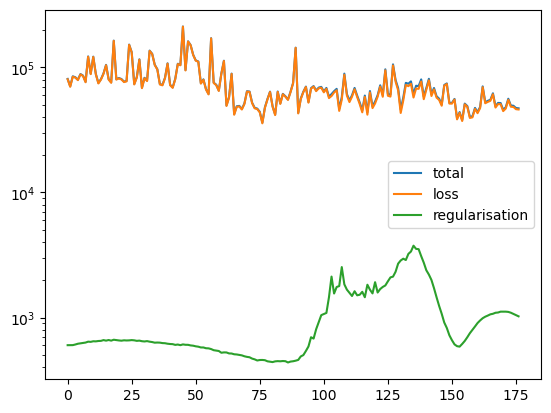

In [12]:
# Let's have a look at the loss over epochs:

df = pd.DataFrame(vi.losses_hist)
df.plot(logy=True)

In [15]:
# We can load the best model to check the results
flow.load_state_dict(vi.best_estimator_state_dict)

<All keys matched successfully>

findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font family 'Arial' not found.
findfont: Font f

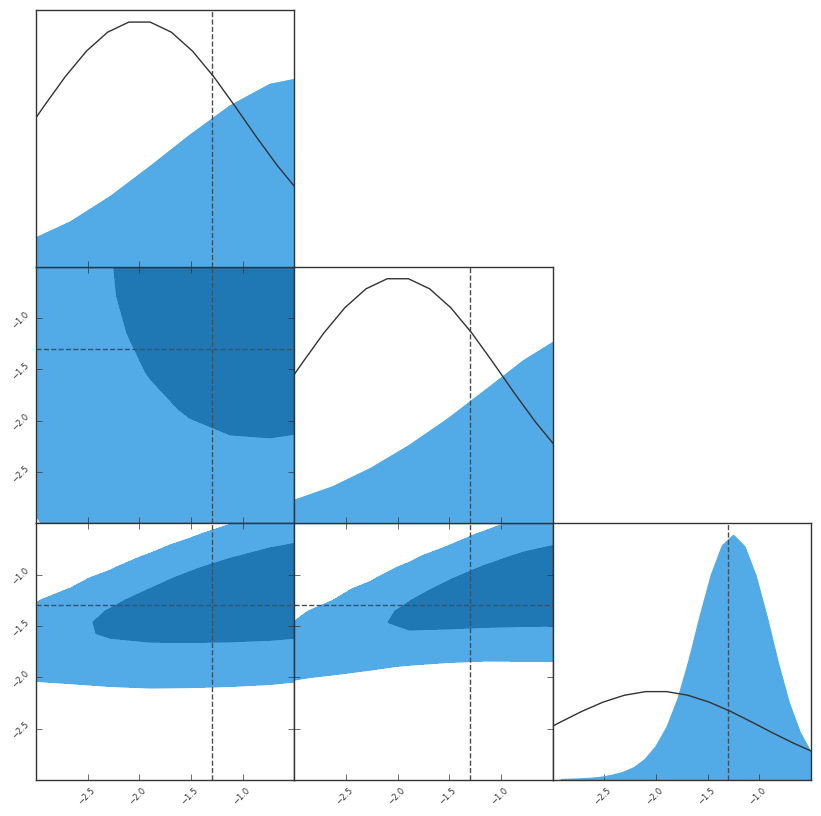

In [18]:
# Plot the final flow posterior approximator and compare it to the real parameters:
samples = flow.sample(50000)[0].cpu().detach().numpy()

#corner(samples, truths=true_parameters.numpy(), smooth=2, range = ((-2, -1.0), (-1.7, -1.0), (-1.4, -1.25)), labels=["initial_fraction_infected", r"$\beta$", r"$\gamma$"]);
#corner(samples, truths=true_parameters.numpy(), smooth=2, labels=["initial_fraction_infected", r"$\beta$", r"$\gamma$"]);
pygtc.plotGTC([samples], truths=true_parameters.cpu().numpy(), figureSize=10, priors=[(-2, 1) for i in range(3)], paramRanges=[(-3.0, -0.5) for i in range(3)]);

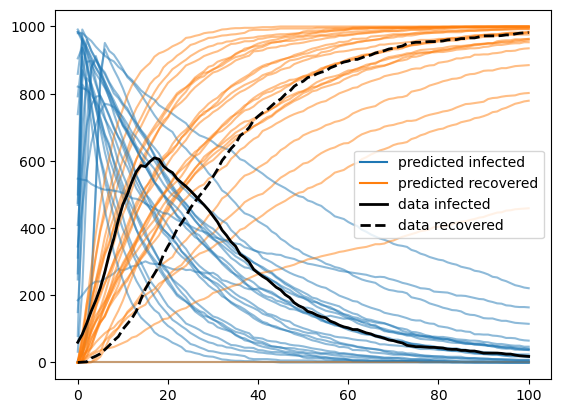

In [21]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(25):
    with torch.no_grad():
        sim_sir = sir.observe(sir.run((flow.sample(1)[0][0])))
    ax.plot(sim_sir[0].cpu().numpy(), color = "C0", alpha=0.5)
    ax.plot(sim_sir[1].cpu().numpy(), color = "C1", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted infected")
ax.plot([], [], color = "C1", label = "predicted recovered")
ax.plot(data[0].cpu(), color = "black", linewidth=2, label = "data infected")
ax.plot(data[1].cpu(), color = "black", linewidth=2, label = "data recovered", linestyle="--")

ax.legend()